In [1]:
# Daniel Armani, PhD : April, 2025

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

print(f"Pandas version: {pd.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")

import math
from tqdm import tqdm
import yfinance as yf
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

print(f"Torch version: {torch.__version__}")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

import random
torch.manual_seed(2025)
np.random.seed(2025)
random.seed(2025)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(2025)

Pandas version: 2.2.2
Seaborn version: 0.13.2
Matplotlib version: 3.10.0
Torch version: 2.6.0+cu124
cuda


In [2]:
# Tickers we want to analyze
tickers = ['AAPL', 'MSFT', 'GOOGL']

# Define time range for historical data
end_date = datetime.now()
start_date = end_date - timedelta(days=1500)  # About 4 years of data

# Fetch data from Yahoo Finance API
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
    return data

# Create dictionary to store stock data
stock_data = {}
for ticker in tickers:
    stock_data[ticker] = fetch_stock_data(ticker, start_date, end_date)
    print(f"Downloaded {len(stock_data[ticker])} rows of data for {ticker}")
    print(f"Available columns: {list(stock_data[ticker].columns)}")

# Dataset class for time series data
class StockDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, index):
        x = self.data[index:index+self.sequence_length]
        y = self.data[index+self.sequence_length, 0]  # Predict only closing price
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Downloaded 1032 rows of data for AAPL
Available columns: [('Adj Close', 'AAPL'), ('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]


Downloaded 1032 rows of data for MSFT
Available columns: [('Adj Close', 'MSFT'), ('Close', 'MSFT'), ('High', 'MSFT'), ('Low', 'MSFT'), ('Open', 'MSFT'), ('Volume', 'MSFT')]


[*********************100%***********************]  1 of 1 completed

Downloaded 1032 rows of data for GOOGL
Available columns: [('Adj Close', 'GOOGL'), ('Close', 'GOOGL'), ('High', 'GOOGL'), ('Low', 'GOOGL'), ('Open', 'GOOGL'), ('Volume', 'GOOGL')]


In [3]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the output from the last time step
        out = self.fc(out[:, -1, :])
        return out

# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Create positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register buffer (not a parameter, but should be saved and restored in state_dict)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, feature_size, d_model, nhead, num_layers, dropout=0.1):
        super(TransformerModel, self).__init__()

        # Feature embedding
        self.embedding = nn.Linear(feature_size, d_model)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(d_model)

        # Transformer encoder layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=True
        )

        # Transformer encoder
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output layer
        self.output_layer = nn.Linear(d_model, 1)

        # Initialize parameters
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src):
        # Linear embedding
        src = self.embedding(src)

        # Add positional encoding
        src = self.positional_encoding(src)

        # Transformer encoder
        output = self.transformer_encoder(src)

        # Get the output from the last time step
        output = self.output_layer(output[:, -1, :])

        return output

In [4]:
# Data preparation function:

def prepare_data(ticker, sequence_length=60, test_size=0.2, include_features=False):
    try:
        if include_features:
            # Safe column access with error handling
            features = []

            # Always include Adj Close or Close
            if 'Adj Close' in stock_data[ticker].columns:
                features.append('Adj Close')
            else:
                features.append('Close')

            # Add additional features if they exist
            if 'High' in stock_data[ticker].columns:
                features.append('High')
            if 'Low' in stock_data[ticker].columns:
                features.append('Low')
            if 'Volume' in stock_data[ticker].columns:
                features.append('Volume')

            print(f"Using features for {ticker}: {features}")
            data = stock_data[ticker][features].values

            # Normalize volume separately if it exists
            if 'Volume' in features:
                vol_idx = features.index('Volume')
                volume_scaler = MinMaxScaler(feature_range=(0, 1))
                data[:, vol_idx:vol_idx+1] = volume_scaler.fit_transform(data[:, vol_idx:vol_idx+1])
        else:
            # Only use closing price
            if 'Adj Close' in stock_data[ticker].columns:
                data = stock_data[ticker]['Adj Close'].values.reshape(-1, 1)
            else:
                data = stock_data[ticker]['Close'].values.reshape(-1, 1)

        # Scale the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_scaled = scaler.fit_transform(data)

        # Split the data into train and test sets
        train_size = int(len(data_scaled) * (1 - test_size))
        train_data = data_scaled[:train_size]
        test_data = data_scaled[train_size-sequence_length:]

        print(f"Training data size: {len(train_data)}")
        print(f"Testing data size: {len(test_data) - sequence_length}")

        return train_data, test_data, scaler

    except Exception as e:
        print(f"Error preparing data for {ticker}: {e}")
        print(f"Available columns: {list(stock_data[ticker].columns)}")
        raise


In [5]:
# Training function:

def train_model(model, train_loader, test_loader, epochs=500, learning_rate=0.001):

    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    model.train()
    train_losses = []

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):

            # Move data to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            loss = criterion(output, target.unsqueeze(1))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    return train_losses

In [6]:
# Evaluation and Prediction Function:

def evaluate_model(model, test_loader, scaler, feature_idx=0):
    model.eval()
    predictions = []
    actual_values = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            predictions.extend(output.cpu().numpy().flatten())
            actual_values.extend(target.cpu().numpy().flatten())

    # If using multi-feature data, we need to format for inverse transform
    if scaler.n_features_in_ > 1:
        # Create a dummy array with zeros
        dummy = np.zeros((len(predictions), scaler.n_features_in_))
        # Put predictions in the right column (usually first column for closing price)
        dummy[:, feature_idx] = predictions
        # Inverse transform
        predictions = scaler.inverse_transform(dummy)[:, feature_idx]

        # Do the same for actual values
        dummy = np.zeros((len(actual_values), scaler.n_features_in_))
        dummy[:, feature_idx] = actual_values
        actual_values = scaler.inverse_transform(dummy)[:, feature_idx]
    else:
        # Scale predictions back to original scale
        predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
        actual_values = scaler.inverse_transform(np.array(actual_values).reshape(-1, 1)).flatten()

    # Calculate metrics
    mse = mean_squared_error(actual_values, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_values, predictions)

    return predictions, actual_values, {'mse': mse, 'rmse': rmse, 'mae': mae}

def predict_future(model, last_sequence, scaler, steps=30, feature_idx=0):
    model.eval()
    future_predictions = []

    # Make a copy to avoid modifying the original sequence
    curr_sequence = last_sequence.copy()

    for _ in range(steps):
        with torch.no_grad():
            x = torch.tensor(curr_sequence, dtype=torch.float32).unsqueeze(0).to(device)
            pred = model(x).cpu().item()  # Get prediction and move to CPU

            # If multi-feature, we need to maintain the structure
            if scaler.n_features_in_ > 1:
                # Create a new row with the predicted value
                new_row = np.zeros((1, scaler.n_features_in_))
                new_row[0, feature_idx] = pred

                # For simplicity, we're using the last values for other features
                for i in range(scaler.n_features_in_):
                    if i != feature_idx:
                        new_row[0, i] = curr_sequence[-1, i]

                # Add the prediction to the sequence and remove the first row
                curr_sequence = np.append(curr_sequence[1:], new_row, axis=0)

                # Inverse transform to get the actual predicted value
                actual_pred = scaler.inverse_transform(new_row)[0, feature_idx]
            else:
                # Add the prediction to the sequence
                curr_sequence = np.append(curr_sequence[1:], [[pred]], axis=0)

                # Inverse transform the prediction
                actual_pred = scaler.inverse_transform([[pred]])[0][0]

            future_predictions.append(actual_pred)

    return future_predictions


=== Training models for AAPL ===
Using features for AAPL: ['Adj Close', 'High', 'Low', 'Volume']
Training data size: 825
Testing data size: 207

Training LSTM model...
Epoch [10/500], Loss: 0.0012
Epoch [20/500], Loss: 0.0010
Epoch [30/500], Loss: 0.0009
Epoch [40/500], Loss: 0.0007
Epoch [50/500], Loss: 0.0007
Epoch [60/500], Loss: 0.0006
Epoch [70/500], Loss: 0.0006
Epoch [80/500], Loss: 0.0005
Epoch [90/500], Loss: 0.0005
Epoch [100/500], Loss: 0.0005
Epoch [110/500], Loss: 0.0005
Epoch [120/500], Loss: 0.0004
Epoch [130/500], Loss: 0.0004
Epoch [140/500], Loss: 0.0005
Epoch [150/500], Loss: 0.0005
Epoch [160/500], Loss: 0.0004
Epoch [170/500], Loss: 0.0005
Epoch [180/500], Loss: 0.0004
Epoch [190/500], Loss: 0.0005
Epoch [200/500], Loss: 0.0004
Epoch [210/500], Loss: 0.0004
Epoch [220/500], Loss: 0.0004
Epoch [230/500], Loss: 0.0004
Epoch [240/500], Loss: 0.0004
Epoch [250/500], Loss: 0.0004
Epoch [260/500], Loss: 0.0004
Epoch [270/500], Loss: 0.0004
Epoch [280/500], Loss: 0.0004


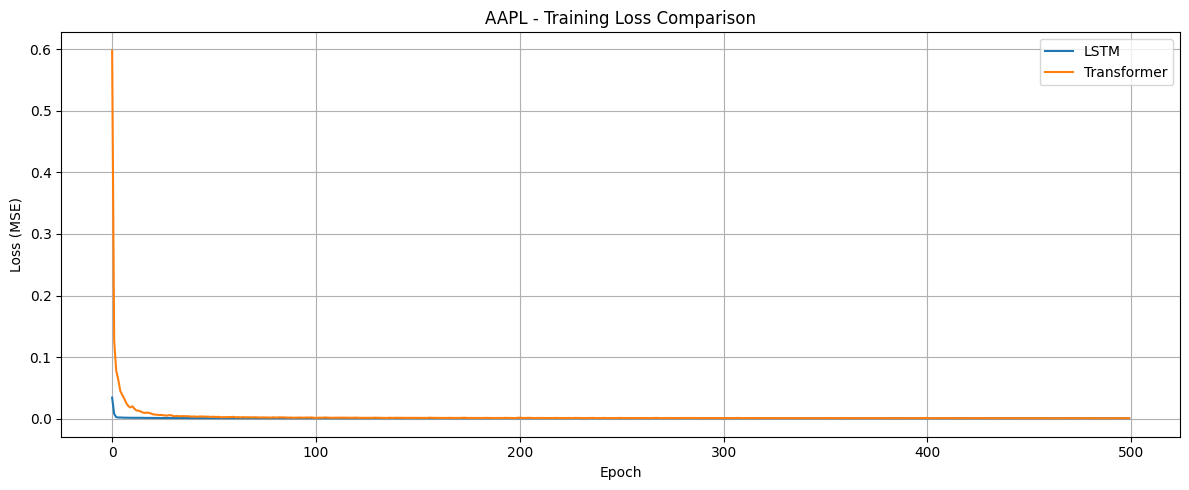

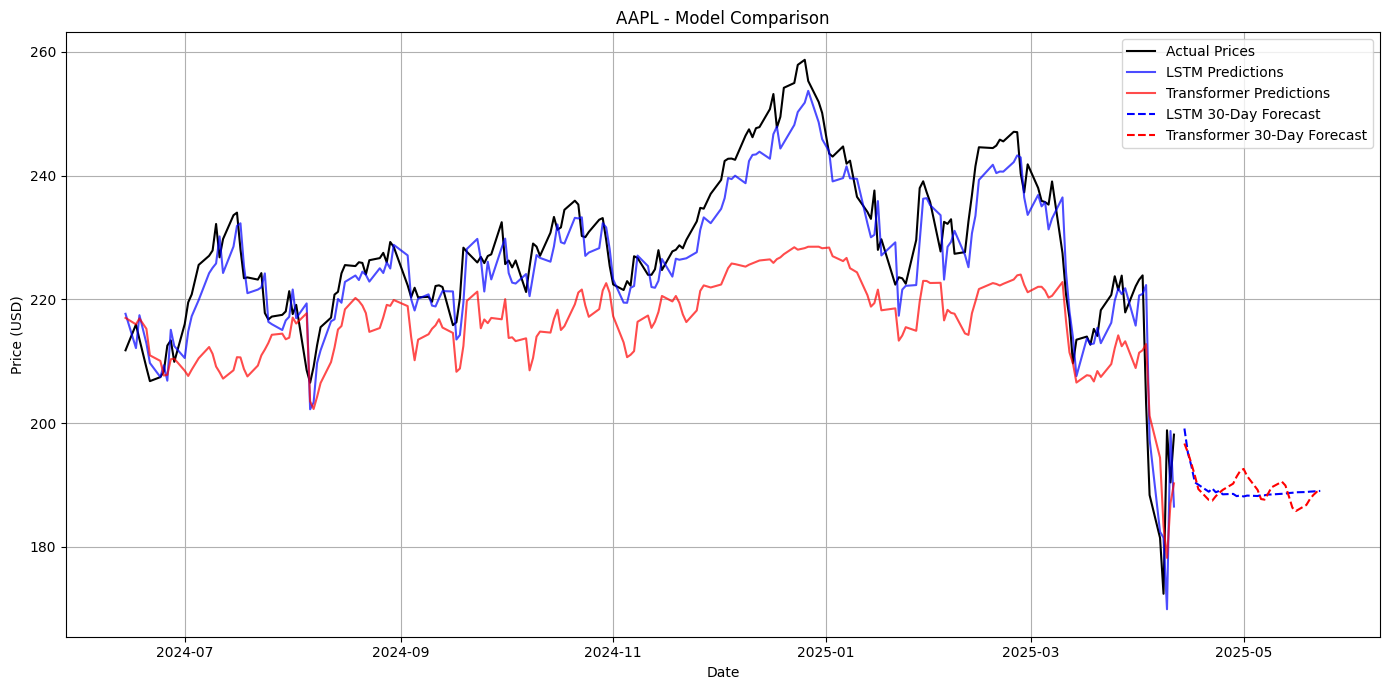


=== Training models for MSFT ===
Using features for MSFT: ['Adj Close', 'High', 'Low', 'Volume']
Training data size: 825
Testing data size: 207

Training LSTM model...
Epoch [10/500], Loss: 0.0015
Epoch [20/500], Loss: 0.0012
Epoch [30/500], Loss: 0.0010
Epoch [40/500], Loss: 0.0009
Epoch [50/500], Loss: 0.0008
Epoch [60/500], Loss: 0.0007
Epoch [70/500], Loss: 0.0007
Epoch [80/500], Loss: 0.0007
Epoch [90/500], Loss: 0.0007
Epoch [100/500], Loss: 0.0007
Epoch [110/500], Loss: 0.0006
Epoch [120/500], Loss: 0.0006
Epoch [130/500], Loss: 0.0006
Epoch [140/500], Loss: 0.0006
Epoch [150/500], Loss: 0.0005
Epoch [160/500], Loss: 0.0005
Epoch [170/500], Loss: 0.0006
Epoch [180/500], Loss: 0.0005
Epoch [190/500], Loss: 0.0005
Epoch [200/500], Loss: 0.0005
Epoch [210/500], Loss: 0.0005
Epoch [220/500], Loss: 0.0005
Epoch [230/500], Loss: 0.0005
Epoch [240/500], Loss: 0.0005
Epoch [250/500], Loss: 0.0005
Epoch [260/500], Loss: 0.0005
Epoch [270/500], Loss: 0.0005
Epoch [280/500], Loss: 0.0004


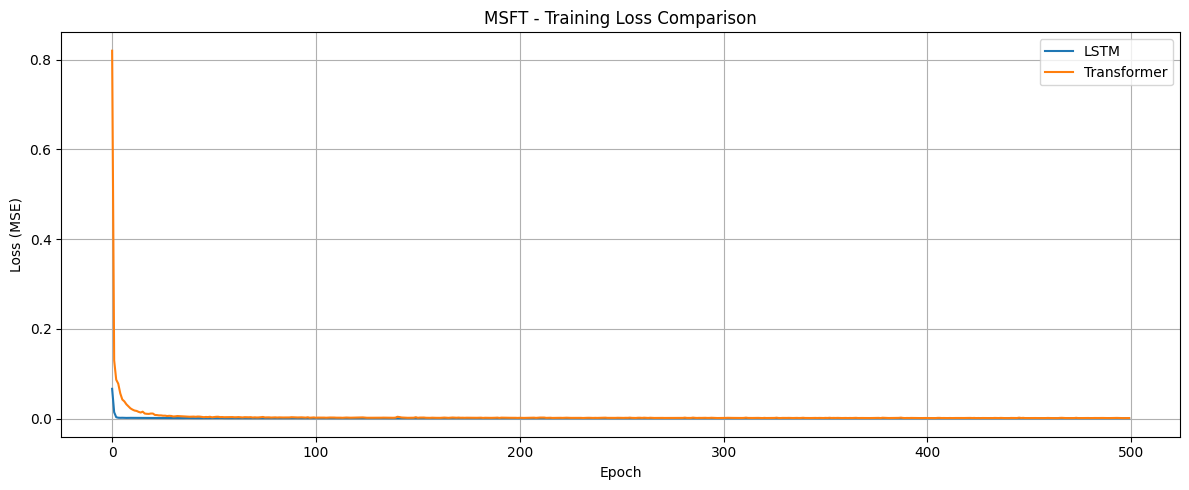

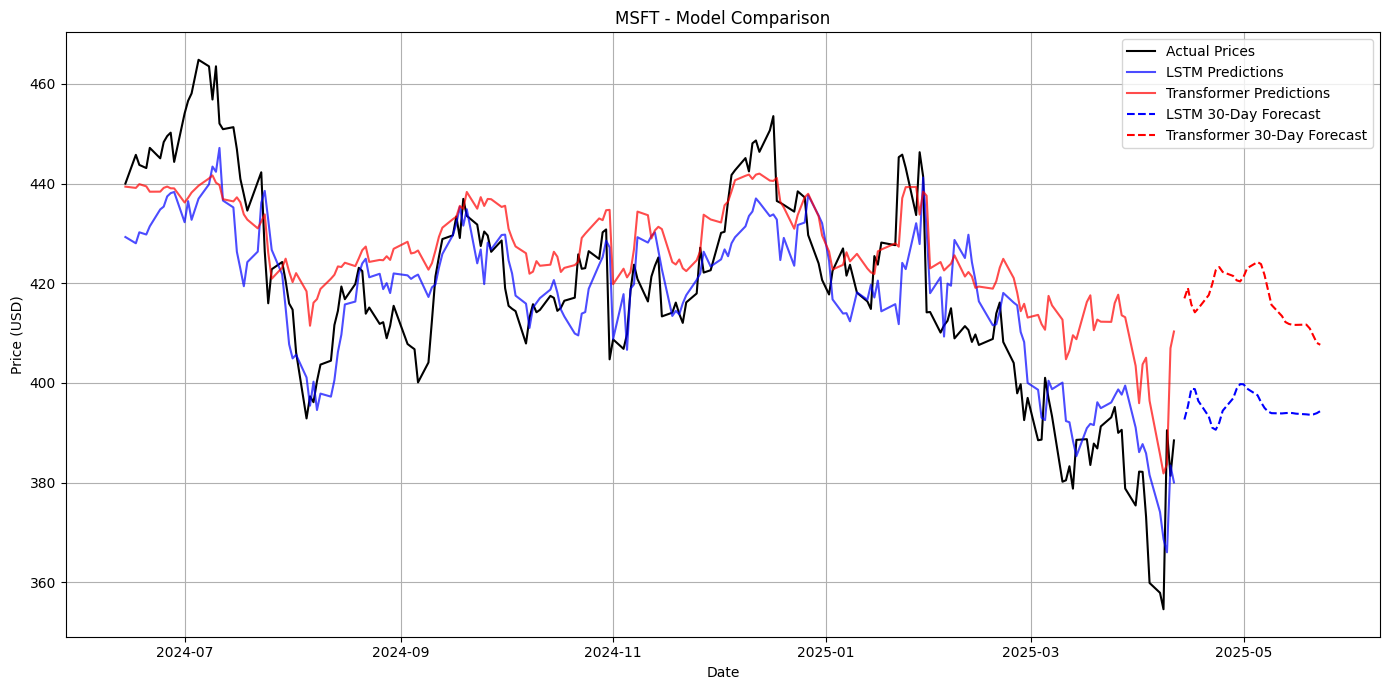


=== Training models for GOOGL ===
Using features for GOOGL: ['Adj Close', 'High', 'Low', 'Volume']
Training data size: 825
Testing data size: 207

Training LSTM model...
Epoch [10/500], Loss: 0.0014
Epoch [20/500], Loss: 0.0011
Epoch [30/500], Loss: 0.0010
Epoch [40/500], Loss: 0.0011
Epoch [50/500], Loss: 0.0008
Epoch [60/500], Loss: 0.0007
Epoch [70/500], Loss: 0.0006
Epoch [80/500], Loss: 0.0006
Epoch [90/500], Loss: 0.0005
Epoch [100/500], Loss: 0.0006
Epoch [110/500], Loss: 0.0005
Epoch [120/500], Loss: 0.0005
Epoch [130/500], Loss: 0.0005
Epoch [140/500], Loss: 0.0005
Epoch [150/500], Loss: 0.0005
Epoch [160/500], Loss: 0.0005
Epoch [170/500], Loss: 0.0005
Epoch [180/500], Loss: 0.0005
Epoch [190/500], Loss: 0.0005
Epoch [200/500], Loss: 0.0005
Epoch [210/500], Loss: 0.0006
Epoch [220/500], Loss: 0.0005
Epoch [230/500], Loss: 0.0005
Epoch [240/500], Loss: 0.0005
Epoch [250/500], Loss: 0.0005
Epoch [260/500], Loss: 0.0005
Epoch [270/500], Loss: 0.0005
Epoch [280/500], Loss: 0.000

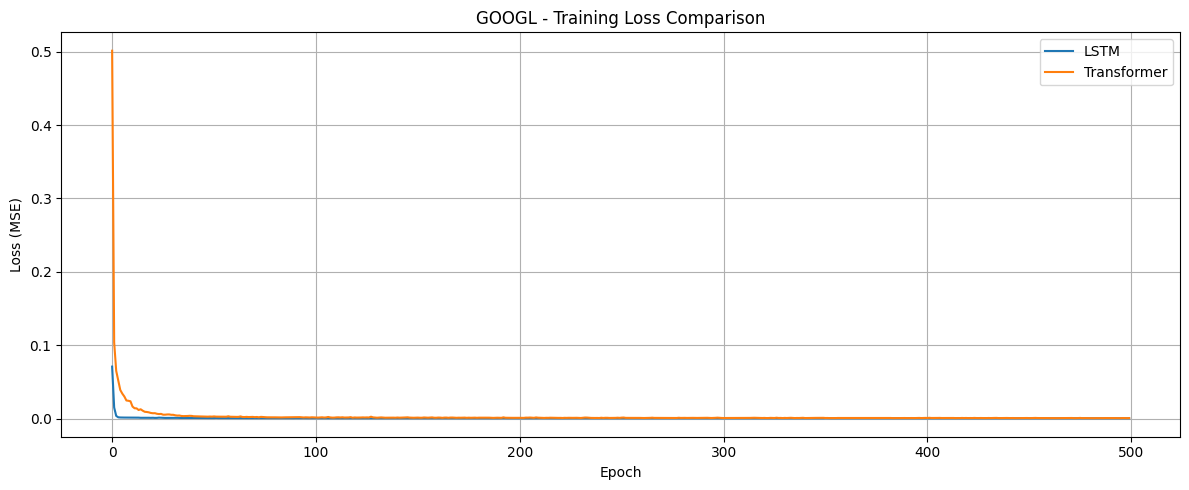

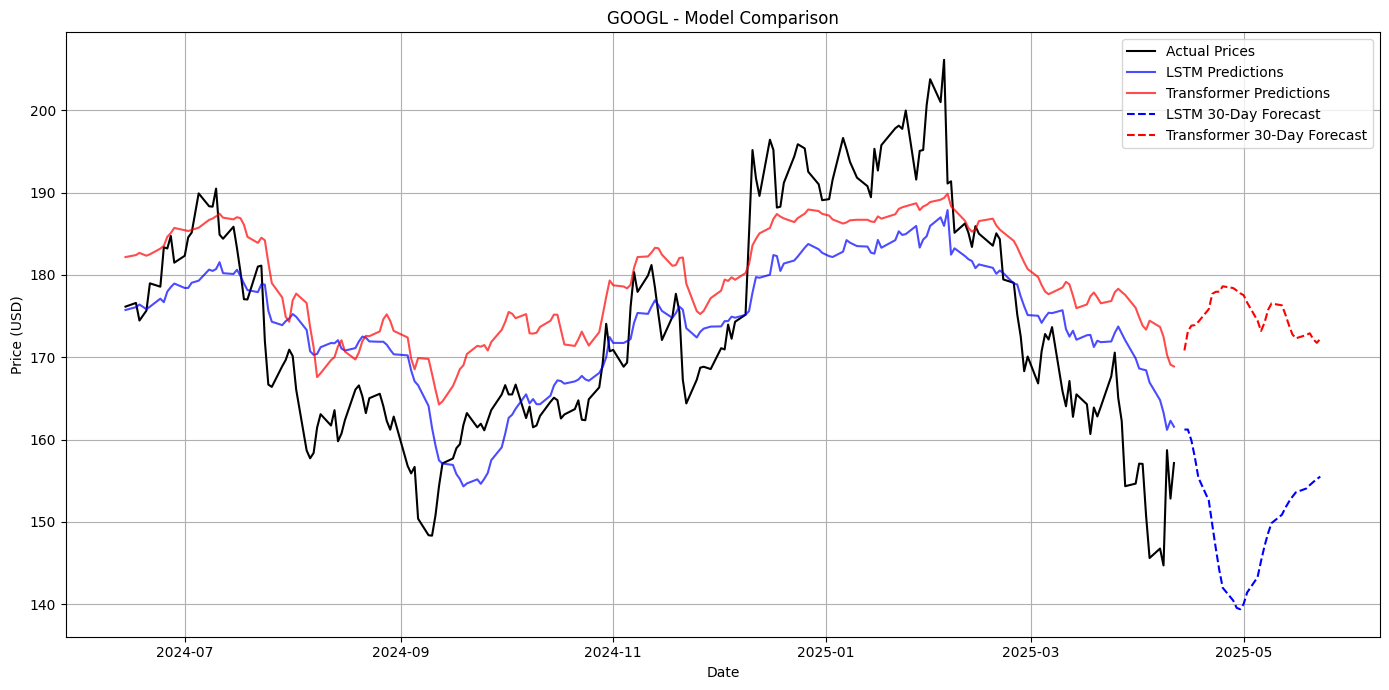

In [7]:
# Comparison (2 models) X (3 stocks):

def compare_models_for_stock(ticker, sequence_length=60, epochs=500, batch_size=32):
    try:
        print(f"\n=== Training models for {ticker} ===")

        # Prepare data
        include_features = True  # Use multiple features for improved prediction
        train_data, test_data, scaler = prepare_data(ticker, sequence_length, include_features=include_features)
        feature_size = train_data.shape[1]

        # Create datasets with data already on the device
        train_dataset = StockDataset(train_data, sequence_length)
        test_dataset = StockDataset(test_data, sequence_length)

        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Initialize LSTM model
        print("\nTraining LSTM model...")
        hidden_size = 64
        num_layers = 2

        lstm_model = LSTMModel(
            input_size=feature_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            output_size=1
        )

        # Train LSTM model
        lstm_losses = train_model(lstm_model, train_loader, test_loader, epochs=epochs)

        # Evaluate LSTM model
        lstm_preds, lstm_actuals, lstm_metrics = evaluate_model(lstm_model, test_loader, scaler)

        # Predict future with LSTM
        lstm_future = predict_future(lstm_model, test_data[-sequence_length:], scaler, steps=30)

        # Initialize Transformer model
        print("\nTraining Transformer model...")
        d_model = 64  # Dimension of model (must be divisible by nhead)
        nhead = 4     # Number of attention heads

        transformer_model = TransformerModel(
            feature_size=feature_size,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_layers
        )

        # Train Transformer model
        transformer_losses = train_model(transformer_model, train_loader, test_loader, epochs=epochs)

        # Evaluate Transformer model
        transformer_preds, transformer_actuals, transformer_metrics = evaluate_model(
            transformer_model, test_loader, scaler
        )

        # Predict future with Transformer
        transformer_future = predict_future(transformer_model, test_data[-sequence_length:], scaler, steps=30)

        # Compare metrics
        print(f"\n--- Performance Metrics for {ticker} ---")
        print("LSTM Model:")
        print(f"  MSE: {lstm_metrics['mse']:.4f}")
        print(f"  RMSE: {lstm_metrics['rmse']:.4f}")
        print(f"  MAE: {lstm_metrics['mae']:.4f}")

        print("\nTransformer Model:")
        print(f"  MSE: {transformer_metrics['mse']:.4f}")
        print(f"  RMSE: {transformer_metrics['rmse']:.4f}")
        print(f"  MAE: {transformer_metrics['mae']:.4f}")

        # Plot training losses
        plt.figure(figsize=(12, 5))
        plt.plot(lstm_losses, label='LSTM')
        plt.plot(transformer_losses, label='Transformer')
        plt.title(f'{ticker} - Training Loss Comparison')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot predictions
        plt.figure(figsize=(14, 7))

        # Dates for actual values and predictions
        test_dates = stock_data[ticker].index[-len(lstm_actuals):]

        # Plot actual values
        plt.plot(test_dates, lstm_actuals, label='Actual Prices', color='black')

        # Plot test predictions
        plt.plot(test_dates, lstm_preds, label='LSTM Predictions', color='blue', alpha=0.7)
        plt.plot(test_dates, transformer_preds, label='Transformer Predictions', color='red', alpha=0.7)

        # Plot future predictions
        future_dates = pd.date_range(start=stock_data[ticker].index[-1] + pd.Timedelta(days=1), periods=30, freq='B')
        plt.plot(future_dates, lstm_future, label='LSTM 30-Day Forecast', linestyle='--', color='blue')
        plt.plot(future_dates, transformer_future, label='Transformer 30-Day Forecast', linestyle='--', color='red')

        plt.title(f'{ticker} - Model Comparison')
        plt.xlabel('Date')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        return {
            'lstm': {
                'model': lstm_model,
                'metrics': lstm_metrics,
                'future': lstm_future
            },
            'transformer': {
                'model': transformer_model,
                'metrics': transformer_metrics,
                'future': transformer_future
            },
            'actual_values': lstm_actuals,
            'test_dates': test_dates,
            'future_dates': future_dates,
            'test_data': test_data,
            'sequence_length': sequence_length
        }
    except Exception as e:
        print(f"Error in model comparison for {ticker}: {e}")
        return None

# Run comparison for each stock
results = {}
for ticker in tickers:
    try:
        results[ticker] = compare_models_for_stock(ticker, epochs=500)
    except Exception as e:
        print(f"Failed to process {ticker}: {e}")



=== Summary of 30-Day Stock Price Predictions ===
-----------------------------------------


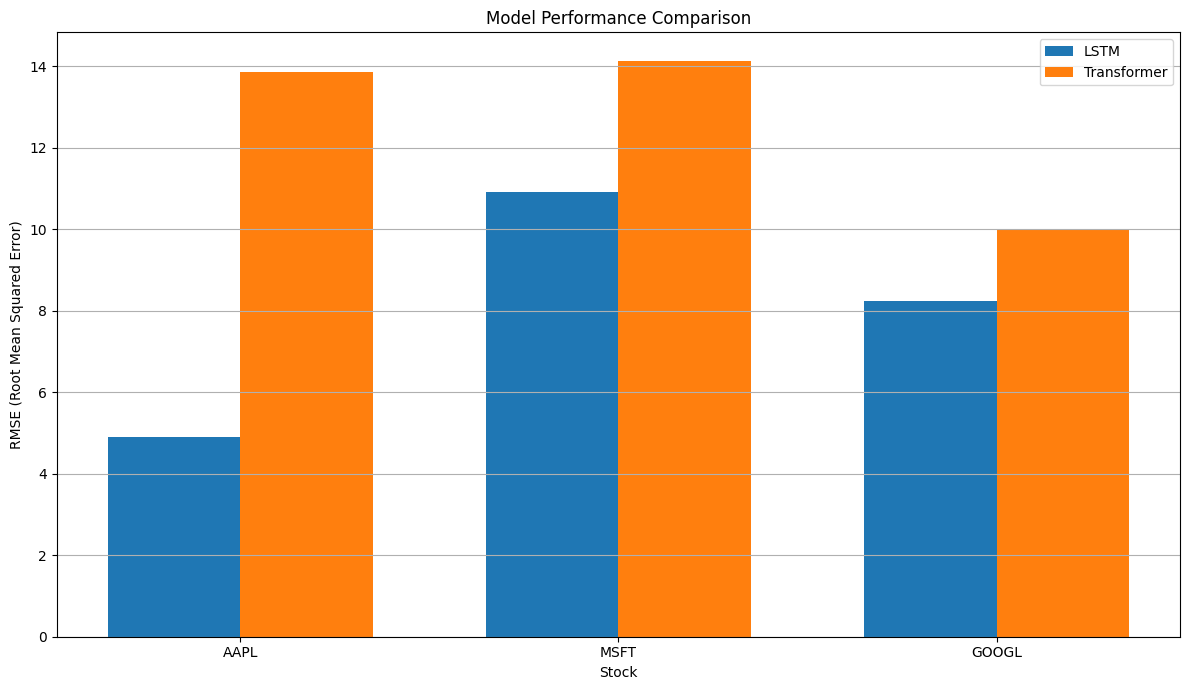

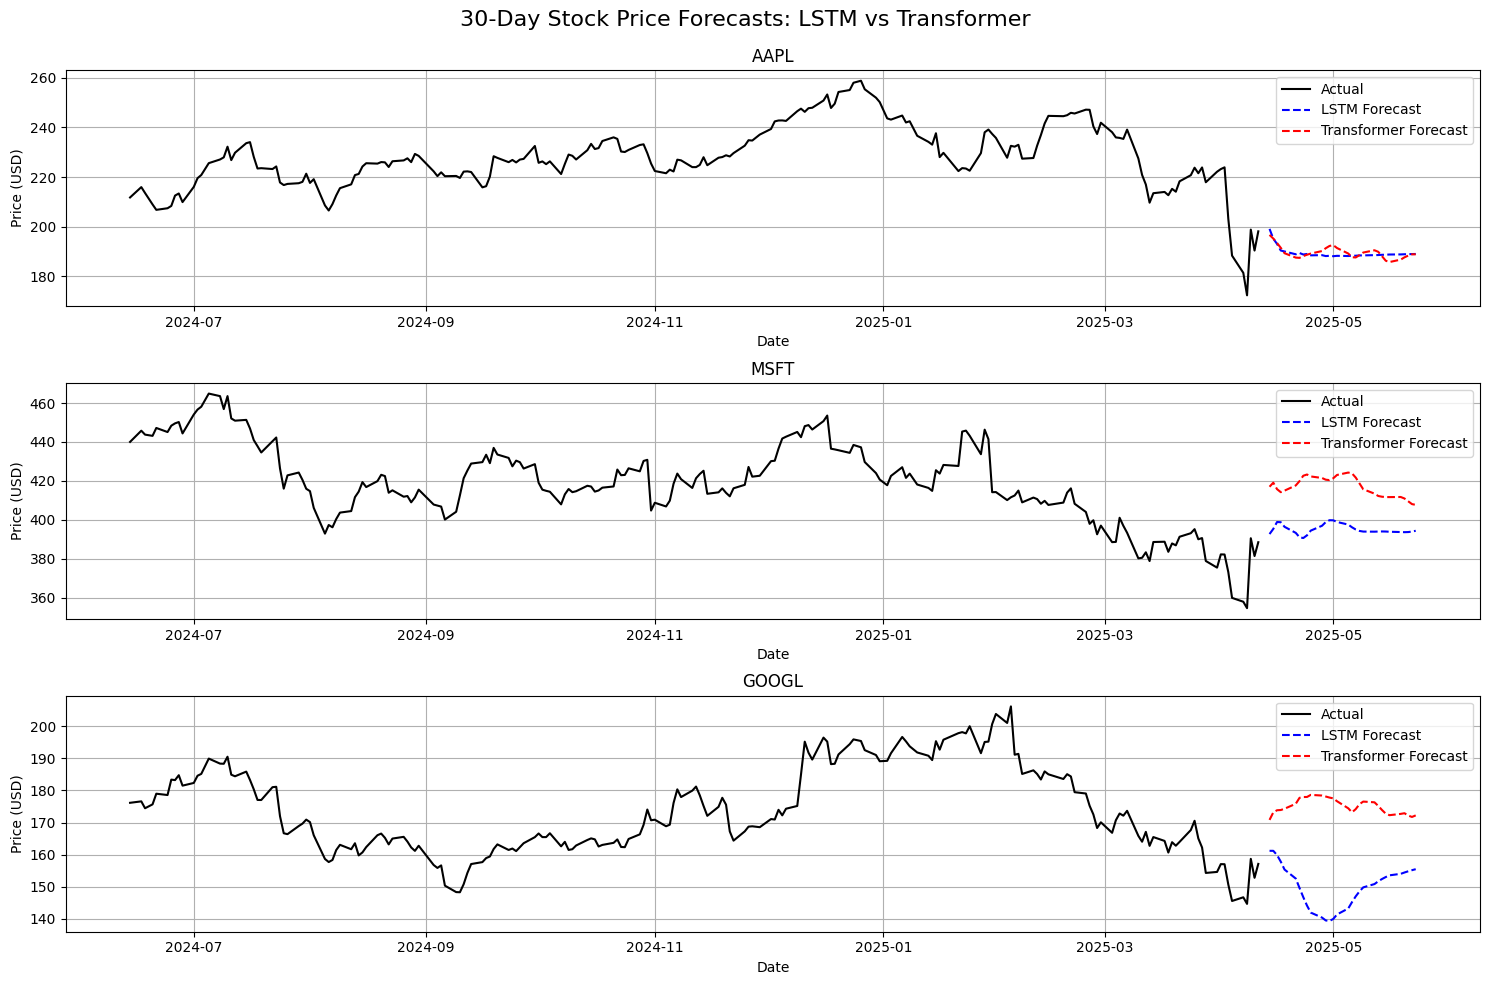

In [8]:
# Process only successful results

valid_tickers = [ticker for ticker in results if results[ticker] is not None]

if valid_tickers:
    # Print summary of predictions
    print("\n=== Summary of 30-Day Stock Price Predictions ===")
    print("-----------------------------------------")

    for ticker in valid_tickers:
        if 'Adj Close' in stock_data[ticker].columns: continue

        print(f"\n=== {ticker} ===")
        current_price = stock_data[ticker]['Adj Close' if 'Adj Close' in stock_data[ticker].columns else 'Close'][-1]
        lstm_price = results[ticker]['lstm']['future'][-1]
        transformer_price = results[ticker]['transformer']['future'][-1]

        lstm_change = ((lstm_price / current_price) - 1) * 100
        transformer_change = ((transformer_price / current_price) - 1) * 100

        better_model = "LSTM" if results[ticker]['lstm']['metrics']['rmse'] < results[ticker]['transformer']['metrics']['rmse'] else "Transformer"

        print(f"\n{ticker}:")
        print(f"  Current Price: ${current_price:.2f}")
        print(f"  LSTM Prediction (30 days): ${lstm_price:.2f} ({lstm_change:+.2f}%)")
        print(f"  Transformer Prediction (30 days): ${transformer_price:.2f} ({transformer_change:+.2f}%)")
        print(f"  Better performing model: {better_model} (lower RMSE)")

    # Create a comparative bar chart for model performance
    if len(valid_tickers) > 0:
        plt.figure(figsize=(12, 7))

        x = np.arange(len(valid_tickers))
        width = 0.35

        lstm_rmse = [results[ticker]['lstm']['metrics']['rmse'] for ticker in valid_tickers]
        transformer_rmse = [results[ticker]['transformer']['metrics']['rmse'] for ticker in valid_tickers]

        plt.bar(x - width/2, lstm_rmse, width, label='LSTM')
        plt.bar(x + width/2, transformer_rmse, width, label='Transformer')

        plt.xlabel('Stock')
        plt.ylabel('RMSE (Root Mean Squared Error)')
        plt.title('Model Performance Comparison')
        plt.xticks(x, valid_tickers)
        plt.legend()
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()

        # Create final comparison chart for all predictions
        plt.figure(figsize=(15, 10))

        for i, ticker in enumerate(valid_tickers):
            plt.subplot(len(valid_tickers), 1, i+1)

            # Plot actual values
            plt.plot(results[ticker]['test_dates'], results[ticker]['actual_values'],
                    label='Actual', color='black')

            # Plot model forecasts
            plt.plot(results[ticker]['future_dates'], results[ticker]['lstm']['future'],
                    label='LSTM Forecast', linestyle='--', color='blue')
            plt.plot(results[ticker]['future_dates'], results[ticker]['transformer']['future'],
                    label='Transformer Forecast', linestyle='--', color='red')

            plt.title(f'{ticker}')
            plt.xlabel('Date')
            plt.ylabel('Price (USD)')
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.suptitle('30-Day Stock Price Forecasts: LSTM vs Transformer', fontsize=16)
        plt.subplots_adjust(top=0.92)
        plt.show()
else:
    print("No successful model comparisons to display")